In [5]:
!pip install -U ultralytics opencv-python tqdm scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 10.5 MB/s  0:00:00 eta 0:00:010:01:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.7.2
    Uninstalling scikit-learn-1.7.2:
      Successfully uninstalled scikit-learn-1.7.2


In [1]:
import os
import cv2
import shutil
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import torch

print("CUDA:", torch.cuda.is_available())


CUDA: True


In [2]:
RAABIN_ROOT = "/home/akash/my_projects/DataSets/Raabin WBC dataset/TestA"
OUT_ROOT = "raabin_rtdetr"


In [3]:
CLASSES = {
    "Basophil": 0,
    "Eosinophil": 1,
    "Lymphocyte": 2,
    "Monocyte": 3,
    "Neutrophil": 4
}


In [4]:
for split in ["train", "val"]:
    os.makedirs(f"{OUT_ROOT}/images/{split}", exist_ok=True)
    os.makedirs(f"{OUT_ROOT}/labels/{split}", exist_ok=True)


In [5]:
def synthetic_bbox(img):
    h, w, _ = img.shape

    bw = 0.9
    bh = 0.9
    xc = 0.5
    yc = 0.5

    return xc, yc, bw, bh


In [6]:
samples = []

for cls_name, cls_id in CLASSES.items():
    cls_dir = os.path.join(RAABIN_ROOT, cls_name)
    for img_name in os.listdir(cls_dir):
        if img_name.lower().endswith(".jpg"):
            samples.append((cls_name, cls_id, os.path.join(cls_dir, img_name)))


In [7]:
train_samples, val_samples = train_test_split(
    samples, test_size=0.2, random_state=42, shuffle=True
)


In [13]:
def write_split(samples, split):
    for cls_name, cls_id, img_path in tqdm(samples):
        img = cv2.imread(img_path)
        if img is None:
            continue

        img_name = os.path.basename(img_path)
        out_img = f"{OUT_ROOT}/images/{split}/{img_name}"
        out_lbl = f"{OUT_ROOT}/labels/{split}/{img_name.replace('.jpg','.txt')}"

        cv2.imwrite(out_img, img)

        xc, yc, bw, bh = synthetic_bbox(img)
        with open(out_lbl, "w") as f:
            f.write(f"{cls_id} {xc} {yc} {bw} {bh}\n")

write_split(train_samples, "train")
write_split(val_samples, "val")


100%|██████████████████████████████████| 868/868 [00:01<00:00, 475.44it/s]


In [8]:
yaml_text = f"""
path: {OUT_ROOT}
train: images/train
val: images/val

names:
"""

for name, idx in CLASSES.items():
    yaml_text += f"  {idx}: {name}\n"

with open(f"{OUT_ROOT}/data.yaml", "w") as f:
    f.write(yaml_text)

print(yaml_text)



path: raabin_rtdetr
train: images/train
val: images/val

names:
  0: Basophil
  1: Eosinophil
  2: Lymphocyte
  3: Monocyte
  4: Neutrophil



## Using Huggingface

In [ ]:
#!pip install -U torch torchvision transformers datasets pillow tqdm pycocotools

In [9]:
import os
import json
import torch
from PIL import Image
from tqdm import tqdm
from datasets import Dataset
from transformers import (
    RTDetrForObjectDetection,
    RTDetrImageProcessor,
    TrainingArguments,
    Trainer
)


In [10]:
DATA_ROOT = "/home/akash/my_projects/DataSets/Raabin WBC dataset/TestA"


In [11]:
CLASSES = {
    "Basophil": 0,
    "Eosinophil": 1,
    "Lymphocyte": 2,
    "Monocyte": 3,
    "Neutrophil": 4
}

ID2LABEL = {v: k for k, v in CLASSES.items()}


In [26]:
import cv2
import numpy as np

def robust_wbc_bbox(
    pil_img,
    min_scale=0.45,
    max_scale=0.75,
    margin=6
):
    """
    Robust WBC bounding box for cropped single-cell images.
    Always returns a reasonable, centered box.
    """
    img = np.array(pil_img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    h, w = gray.shape

    # --- Attempt segmentation ---
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(
        blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    # --- Default: centered conservative box ---
    default_bw = int(0.6 * w)
    default_bh = int(0.6 * h)
    cx, cy = w // 2, h // 2

    best_box = [
        cx - default_bw // 2,
        cy - default_bh // 2,
        default_bw,
        default_bh,
    ]

    if contours:
        cnt = max(contours, key=cv2.contourArea)
        x, y, bw, bh = cv2.boundingRect(cnt)

        # --- Clamp size ---
        bw = int(np.clip(bw, min_scale * w, max_scale * w))
        bh = int(np.clip(bh, min_scale * h, max_scale * h))

        # --- Re-center box ---
        best_box = [
            cx - bw // 2,
            cy - bh // 2,
            bw,
            bh,
        ]

    # --- Final safety clamp ---
    x, y, bw, bh = best_box
    x = max(0, x - margin)
    y = max(0, y - margin)
    bw = min(w - x, bw + 2 * margin)
    bh = min(h - y, bh + 2 * margin)

    return [x, y, bw, bh]




In [27]:
records = []

for cls_name, cls_id in CLASSES.items():
    cls_dir = os.path.join(DATA_ROOT, cls_name)
    for img_name in os.listdir(cls_dir):
        if not img_name.lower().endswith(".jpg"):
            continue

        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path).convert("RGB")
        w, h = img.size

        box = robust_wbc_bbox(img)

        records.append({
            "image": img,
            "annotations": [{
                "bbox": box,
                "category_id": cls_id,
                "area": box[2] * box[3],
                "iscrowd": 0
            }]
        })


In [20]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [21]:
def visualize_samples(records, id2label, n=5):
    samples = random.sample(records, n)

    for sample in samples:
        img = sample["image"]
        ann = sample["annotations"][0]

        x, y, w, h = ann["bbox"]
        label = id2label[ann["category_id"]]

        fig, ax = plt.subplots(1, figsize=(6, 6))
        ax.imshow(img)
        ax.axis("off")

        rect = patches.Rectangle(
            (x, y),
            w,
            h,
            linewidth=2,
            edgecolor="red",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x,
            y - 5,
            label,
            color="red",
            fontsize=12,
            backgroundcolor="white"
        )

        plt.show()


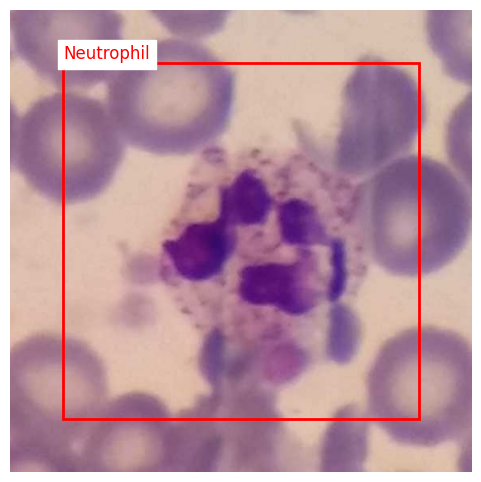

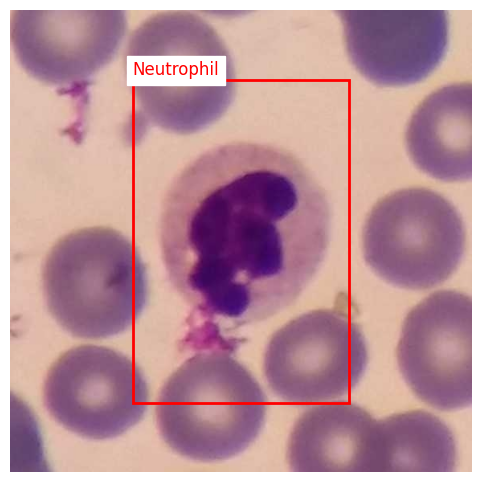

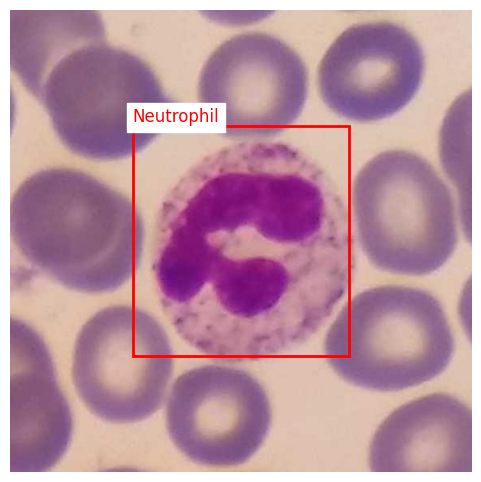

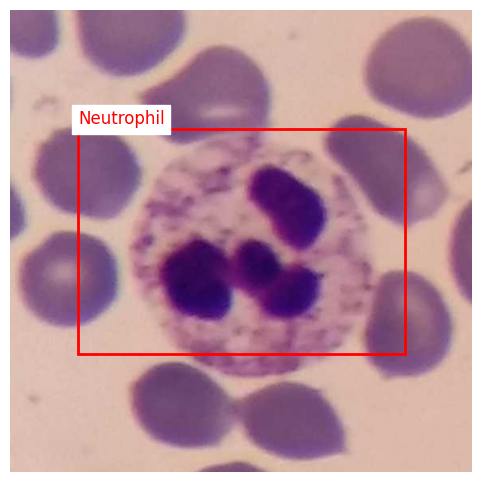

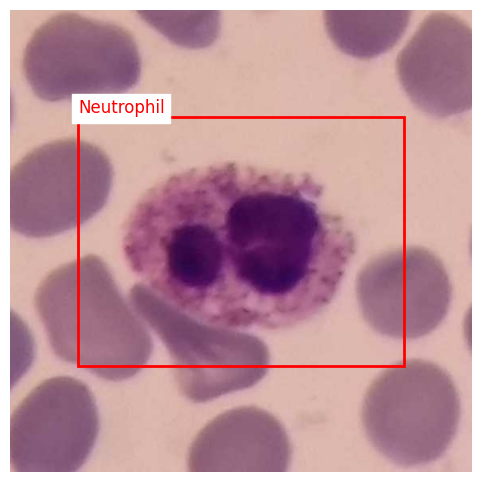

In [29]:
visualize_samples(records, ID2LABEL, n=5)


In [30]:
dataset = Dataset.from_list(records)
dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_ds = dataset["train"]
val_ds = dataset["test"]


In [46]:
from transformers import RTDetrImageProcessor

processor = RTDetrImageProcessor.from_pretrained(
    "PekingU/rtdetr_r50vd",
    format="coco_detection"
)


In [47]:
from transformers import RTDetrForObjectDetection

model = RTDetrForObjectDetection.from_pretrained(
    "PekingU/rtdetr_r50vd",
    num_labels=len(CLASSES),
    id2label=ID2LABEL,
    label2id=CLASSES,
    ignore_mismatched_sizes=True
)


Loading weights:   0%|          | 0/764 [00:00<?, ?it/s]

RTDetrForObjectDetection LOAD REPORT from: PekingU/rtdetr_r50vd
Key                                                 | Status   |                                                                                      
----------------------------------------------------+----------+--------------------------------------------------------------------------------------
model.decoder.class_embed.{0, 1, 2, 3, 4, 5}.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80, 256]) vs model:torch.Size([5, 256])
model.decoder.class_embed.{0, 1, 2, 3, 4, 5}.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80]) vs model:torch.Size([5])          
model.enc_score_head.weight                         | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([80, 256]) vs model:torch.Size([5, 256])
model.denoising_class_embed.weight                  | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([81, 256]) vs model:torch.Size([6, 256])
model.enc_score_head.bias     

In [48]:
def transform(batch):
    images = batch["image"]
    anns = batch["annotations"]

    coco_annotations = []
    for i, ann_list in enumerate(anns):
        coco_annotations.append({
            "image_id": i,
            "annotations": ann_list
        })

    encoding = processor(
        images=images,
        annotations=coco_annotations,
        return_tensors="pt"
    )

    return encoding



In [49]:
train_ds.set_transform(transform)
val_ds.set_transform(transform)


In [61]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./rtdetr_raabin",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-4,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=50,
    remove_unused_columns=False,
    fp16=torch.cuda.is_available(),
    report_to=[]
)


In [62]:
def collate_fn(batch):
    out = {
        "pixel_values": torch.stack([x["pixel_values"] for x in batch]),
        "labels": [x["labels"] for x in batch],  # must stay a list
    }

    # pixel_mask is optional for RT-DETR
    if "pixel_mask" in batch[0]:
        out["pixel_mask"] = torch.stack([x["pixel_mask"] for x in batch])

    return out



In [63]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
)


In [64]:
trainer.train()


Epoch,Training Loss,Validation Loss
1,21.099678,10.421786
2,17.409501,9.388404
3,14.274005,8.441723


TrainOutput(global_step=2604, training_loss=19.154218588739678, metrics={'train_runtime': 1040.2875, 'train_samples_per_second': 10.01, 'train_steps_per_second': 2.503, 'total_flos': 3.2809473046831104e+18, 'train_loss': 19.154218588739678, 'epoch': 3.0})

In [65]:
trainer.save_model("./rtdetr_raabin_final")
processor.save_pretrained("./rtdetr_raabin_final")


['./rtdetr_raabin_final/preprocessor_config.json']

### Next Day (using saved trained model)

In [ ]:
#!pip install -U torch torchvision transformers pillow matplotlib

In [6]:
import torch
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image


In [7]:
MODEL_DIR = "./rtdetr_raabin_final"   # where you saved model + processor
DATA_ROOT = "/home/akash/my_projects/DataSets/Raabin WBC dataset/TestA"


In [8]:
CLASSES = {
    "Basophil": 0,
    "Eosinophil": 1,
    "Lymphocyte": 2,
    "Monocyte": 3,
    "Neutrophil": 4
}

ID2LABEL = {v: k for k, v in CLASSES.items()}


In [9]:
from transformers import RTDetrForObjectDetection, RTDetrImageProcessor

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = RTDetrForObjectDetection.from_pretrained(MODEL_DIR).to(DEVICE)
model.eval()

processor = RTDetrImageProcessor.from_pretrained(MODEL_DIR)

print("Model & processor loaded from disk")


Loading weights:   0%|          | 0/764 [00:00<?, ?it/s]

Model & processor loaded from disk


In [10]:
def collect_images(root, max_per_class=50):
    images = []
    for cls in CLASSES:
        cls_dir = f"{root}/{cls}"
        files = [f for f in os.listdir(cls_dir) if f.lower().endswith(".jpg")]
        for f in files[:max_per_class]:
            images.append((cls, Image.open(f"{cls_dir}/{f}").convert("RGB")))
    return images

import os
images = collect_images(DATA_ROOT)


In [11]:
def predict_and_visualize(
    image,
    model,
    processor,
    id2label,
    score_thresh=0.4
):
    inputs = processor(images=image, return_tensors="pt").to(DEVICE)

    with torch.no_grad():
        outputs = model(**inputs)

    target_sizes = torch.tensor([image.size[::-1]]).to(DEVICE)
    results = processor.post_process_object_detection(
        outputs,
        target_sizes=target_sizes,
        threshold=score_thresh
    )[0]

    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(image)
    ax.axis("off")

    for box, score, label in zip(
        results["boxes"],
        results["scores"],
        results["labels"]
    ):
        x1, y1, x2, y2 = box.cpu().numpy()
        rect = patches.Rectangle(
            (x1, y1),
            x2 - x1,
            y2 - y1,
            linewidth=2,
            edgecolor="lime",
            facecolor="none"
        )
        ax.add_patch(rect)

        ax.text(
            x1,
            y1 - 5,
            f"{id2label[label.item()]}: {score:.2f}",
            color="lime",
            fontsize=10,
            backgroundcolor="black"
        )

    plt.show()


GT class: Eosinophil


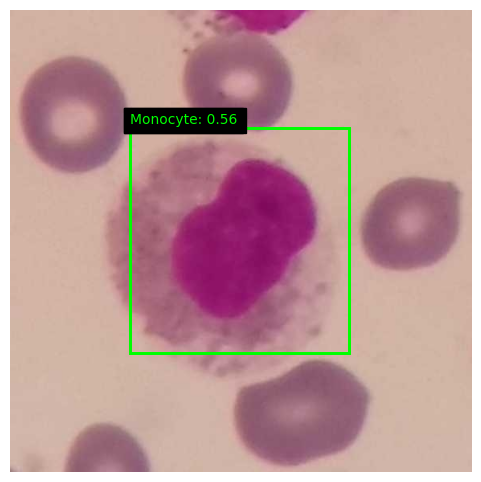

GT class: Monocyte


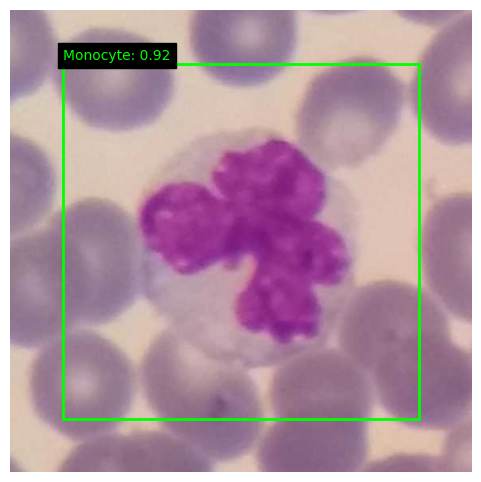

GT class: Monocyte


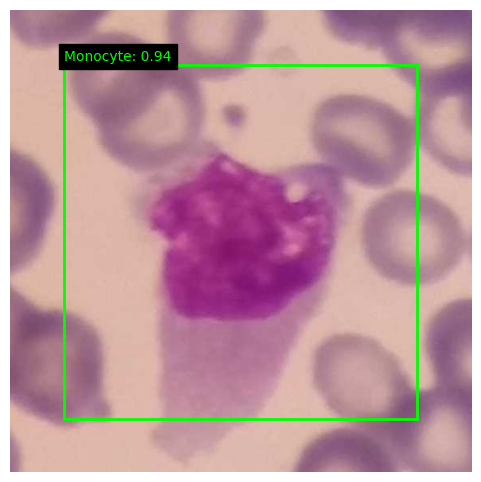

GT class: Eosinophil


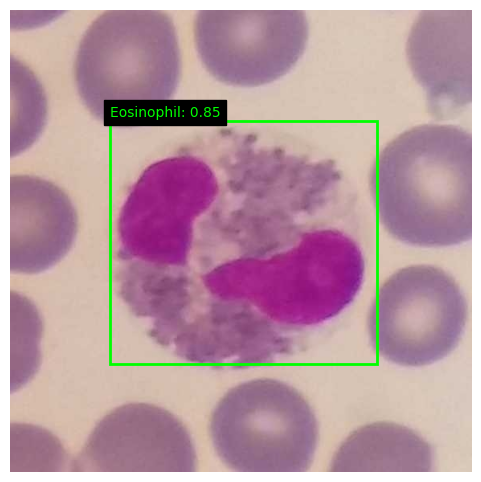

GT class: Eosinophil


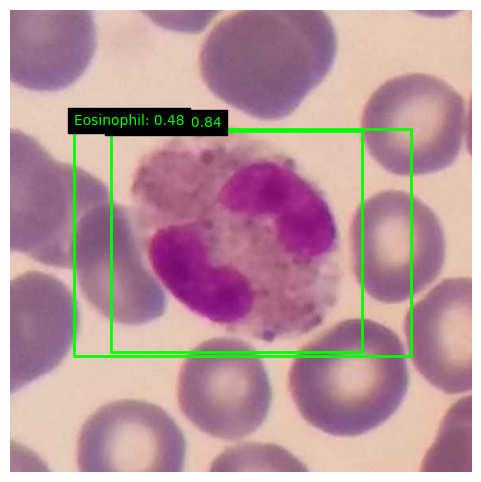

In [12]:
samples = random.sample(images, 5)

for cls, img in samples:
    print("GT class:", cls)
    predict_and_visualize(
        image=img,
        model=model,
        processor=processor,
        id2label=ID2LABEL,
        score_thresh=0.4
    )


In [13]:
y_true = []
y_pred = []

CONF_THRESH = 0.3  # low threshold, we always expect 1 object

for gt_class, gt_id in CLASSES.items():
    cls_dir = os.path.join(DATA_ROOT, gt_class)
    files = [f for f in os.listdir(cls_dir) if f.lower().endswith(".jpg")]

    for fname in tqdm(files, desc=f"Evaluating {gt_class}"):
        img = Image.open(os.path.join(cls_dir, fname)).convert("RGB")

        inputs = processor(images=img, return_tensors="pt").to(DEVICE)

        with torch.no_grad():
            outputs = model(**inputs)

        target_sizes = torch.tensor([img.size[::-1]]).to(DEVICE)
        results = processor.post_process_object_detection(
            outputs,
            target_sizes=target_sizes,
            threshold=CONF_THRESH
        )[0]

        y_true.append(gt_id)

        if len(results["scores"]) == 0:
            # model predicted nothing
            y_pred.append(-1)
        else:
            best_idx = results["scores"].argmax()
            y_pred.append(results["labels"][best_idx].item())


Evaluating Neutrophil: 100%|████████████████| 2660/2660 [01:36<00:00, 27.54it/s]


In [15]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [16]:
y_true = np.array(y_true)
y_pred = np.array(y_pred)

valid = y_pred != -1  # ignore "no prediction" cases

print("Top-1 Accuracy:", accuracy_score(y_true[valid], y_pred[valid]))
print("\nClassification Report:\n")
print(
    classification_report(
        y_true[valid],
        y_pred[valid],
        target_names=[ID2LABEL[i] for i in range(len(CLASSES))]
    )
)


Top-1 Accuracy: 0.9687426556991774

Classification Report:

              precision    recall  f1-score   support

    Basophil       1.00      1.00      1.00         5
  Eosinophil       0.90      0.89      0.89       322
  Lymphocyte       0.97      0.98      0.98      1034
    Monocyte       0.83      0.81      0.82       234
  Neutrophil       0.99      0.99      0.99      2660

    accuracy                           0.97      4255
   macro avg       0.94      0.93      0.94      4255
weighted avg       0.97      0.97      0.97      4255



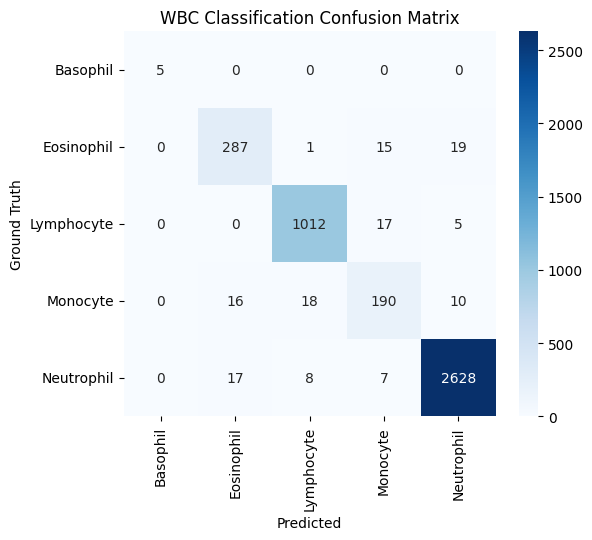

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true[valid], y_pred[valid])

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    xticklabels=CLASSES.keys(),
    yticklabels=CLASSES.keys(),
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.title("WBC Classification Confusion Matrix")
plt.show()
